# **Script and outputs for training a CNN for model selection, perform cross-validation and predict the most likely model from empirical data in the species *Euphorbia segueriana*.**
From the manuscript Kirschner & Perez et al. (2022) "Congruent evolutionary responses of European steppe biota to late Quaternary climate change: insights from convolutional neural network-based demographic modeling".

All required files are available at the GitHub directory, except for the simulations, that can be downloaded here: https://drive.google.com/file/d/1XsOb03YkmwPsLT0DcSV8iWroNUJ-n0NV/view?usp=sharing. We will do the download with the next command.

##**Section 1: Building the CNN.**

In [1]:
#You need to download the empirical data.
!gdown --id 1XsOb03YkmwPsLT0DcSV8iWroNUJ-n0NV

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1XsOb03YkmwPsLT0DcSV8iWroNUJ-n0NV
From (redirected): https://drive.google.com/uc?id=1XsOb03YkmwPsLT0DcSV8iWroNUJ-n0NV&confirm=t&uuid=95ebb5ba-882c-4cee-9287-72c1d7f58f28
To: /content/Part1_Dem_Models_simulations.zip
100% 47.6M/47.6M [00:00<00:00, 47.7MB/s]


In [2]:
# Import all required modules.

import sys, os
import numpy as np
import time
import random
from random import shuffle, choice
import keras
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import load_model
#from keras.utils import np_utils
import sklearn.metrics as metrics
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In the next cell we define the CNN architecture. Try to recognize each part of the architecture and associate them to the concepts presented during the lecture and what are their functions. Take notes if there is anything new or if you are not sure of what is the function of any of these parts.

In [3]:
# Define parameters for the CNN run.
batch_size = 128
### how much interations to train the network
epochs = 50

###n of models
num_classes = 3


# Define the CNN architecture.
def create_cnn(xtest):
	inputShape = (xtest.shape[1], xtest.shape[2])
	## image size. images need to have EXACTLY the same size
	inputs = Input(shape=inputShape)
	x = inputs
	## 1D convolution - less computational intensive and is also invariant to the samples order;
	x = Conv1D(256, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(128, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(128, kernel_size=2, activation='relu')(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	### Linearising the image as in the initial step. From this point on the network behaves as a Multi-Layer Perceptron.
	x = Flatten()(x)
	x = Dense(128, activation='relu')(x)
	x = Dropout(0.5)(x)
	x = Dense(128, activation='relu')(x)
	x = Dropout(0.5)(x)
	x = Dense(num_classes, activation="softmax")(x)

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

## **Section 2: Train the network with 1,000 simulations from each model**

Now we are going to load the simulated data and train the network. First, unzip the folder containing the simulations and load them as 3-dimensional NumPy arrays (simulation, SNPs, samples). Associate each simulation with the appropriate label and shuffle their order.

In [4]:
#Unzip simulations
!unzip "/content/Part1_Dem_Models_simulations.zip"

#Load simulations from each model as a separate NumPy array
u1 = np.load("/content/Part1_Dem_Models_simulations/simulations/trainingSims/simModel1.npy",mmap_mode='r')
u2 = np.load("/content/Part1_Dem_Models_simulations/simulations/trainingSims/simModel2.npy",mmap_mode='r')
u3 = np.load("/content/Part1_Dem_Models_simulations/simulations/trainingSims/simModel3.npy",mmap_mode='r')

# Combine all arrays.
x=np.concatenate((u1,u2,u3),axis=0)

#For the real data we don't know which alleles are ancestral or derived.
#This function to transforms major alleles in -1 and minor in 1
for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 1] = -1
      x[arr][idx][x[arr][idx] == 0] = 1
    else:
      x[arr][idx][x[arr][idx] == 0] = -1

# Label each simulated array.
y=[0 for i in range(len(u1))]
y.extend([1 for i in range(len(u2))])
y.extend([2 for i in range(len(u3))])
y = np.array(y)

#delete temporary files to free memory.
del (u1,u2,u3)

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(x)))
shuffle(shf)
#Shuffle the labels (models)
y = y[shf]
#Shuffle the simulations using the same order of the labels.
x = x[shf]


Archive:  /content/Part1_Dem_Models_simulations.zip
replace Part1_Dem_Models_simulations/Part1_Dem_Models_Esegueriana.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [5]:
# Print label and simulations length, these should be the same.
print (len(x), len(y))

# Check array sizes as well just to be sure.
print (x.shape)

print (y.shape)

3000 3000
(3000, 1000, 270)
(3000,)


In [6]:
y

array([2, 0, 2, ..., 0, 2, 1])

Now let's visualize the simulations as images. Check if you can extract some information from the images. For example, is it possible to separate individuals from the two different populations (remember that each sample is in a different column, and that the population samples are separated).

2


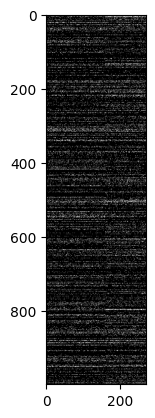

In [7]:
#Print the label and export an image from the training data, to visualize its appearance
print(y[0])
import matplotlib.pyplot as plt
plt.imshow(x[0],cmap='gray', vmin=-1, vmax=1)

np.int64(0)

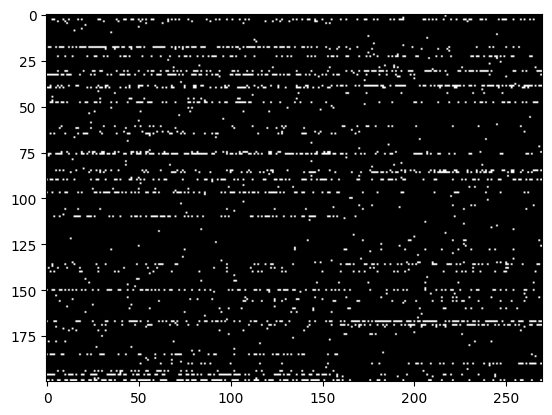

In [8]:
#You can also visualize a subset of the SNPs to better see the polymorphism.
import matplotlib.pyplot as plt
plt.imshow(x[1][0:200],cmap='gray', vmin=-1, vmax=1)
y[1]

In [9]:
#you can also visualize the array values (-1 for major and 1 to minor).
x[0]

array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 1, -1, -1, ...,  1,  1,  1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int8)

Now we need to make the simulations look more like the real data. For that, we need to convert ancestral/derived alleles into major/minor. We also need to add missing data to the matrices.

In [10]:
# We will add missing data to the simulations as 0s.
# This is necessary beacuse the real data contains missing genotypes and
# we need to train the network to be able to recognize it.

#Add missing data (coded as 0s) to the simulated matrices
# as a percentage according to the empirical data (15% in E. segueriana).
missD_perc = 15
missD = int(x.shape[1]*x.shape[2]*(missD_perc/100))
for i in range(x.shape[0]):
    indices_2d = np.random.choice(x.shape[1], size=missD, replace=True)
    indices_3d = np.random.choice(x.shape[2], size=missD, replace=True)
    x[i, indices_2d, indices_3d] = 0
del(missD)

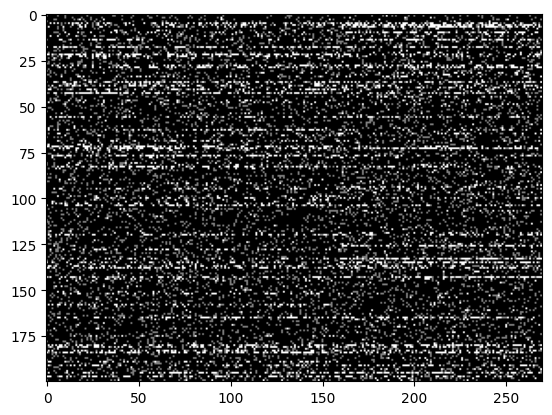

In [11]:
#Export an image from the training data, to visualize its appearance.
#Note how missing data (in grey) make it much more difficult to detect patterns.
import matplotlib.pyplot as plt
plt.imshow(x[0][0:200],cmap='gray', vmin=-1, vmax=1)

In [12]:
#And visualize the array values.
x[0]

array([[-1, -1,  0, ...,  0, -1, -1],
       [ 0, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [ 1, -1, -1, ...,  1,  1,  1],
       [-1, -1, -1, ...,  0, -1, -1],
       [-1, -1,  0, ..., -1, -1, -1]], dtype=int8)

Now we need to separate the training simulations into the training and validation sets. Do you remember what are these sets used to? We don't need to define the test now, but do you remember what will it be used to?

We will also compile the architecture, define the optimzer and set an Early Stopping approach.

In [13]:
# Separate train (75%) and validate (25%) sets.
xtrain, xval = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, yval = y[int(len(y)*.25):], y[:int(len(y)*.25)]

#Dividind into classes
yval = np.eye(num_classes)[yval]
ytrain = np.eye(num_classes)[ytrain]

# Create the CNN network.
model = create_cnn(xval)

# Compile the CNN.
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer='Adam',
	              metrics=['accuracy'])

# We will use early stopping and save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=50, verbose=0, mode='max', restore_best_weights=True)
### stop training when validation error increases (wait 50 epochs to see if there is any improvement).

# Check the architecture.
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 270)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 999, 256)       │       138,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d               │ (None, 499, 256)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 499, 256)       │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 498, 128)       │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_1             │ (None, 249, 128)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 249, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 248, 128)       │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_2             │ (None, 124, 128)       │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 124, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15872)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,031,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,287,747 (8.73 MB)

 Trainable params: 2,286,723 (8.72 MB)

 Non-trainable params: 1,024 (4.00 KB)

Now it's time to train the network. This will take some time. While it's training we can discuss the previous steps of the script.

In [14]:
#Run the CNN
history = model.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xval, yval),callbacks=[earlyStopping])

# Save the model.
model.save(filepath='Trained_Esegueriana._MissingData.acc.keras')

Epoch 1/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 27s 1s/step - accuracy: 0.5749 - loss: 1.0907 - val_accuracy: 0.3640 - val_loss: 24.1425
Epoch 2/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 19s 98ms/step - accuracy: 0.7573 - loss: 0.6271 - val_accuracy: 0.3640 - val_loss: 31.1319
Epoch 3/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 86ms/step - accuracy: 0.8174 - loss: 0.4605 - val_accuracy: 0.3640 - val_loss: 19.0225
Epoch 4/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9120 - loss: 0.2446 - val_accuracy: 0.3293 - val_loss: 9.3228
Epoch 5/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9316 - loss: 0.1741 - val_accuracy: 0.3293 - val_loss: 15.4047
Epoch 6/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9522 - loss: 0.1281 - val_accuracy: 0.3293 - val_loss: 22.0839
Epoch 7/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 84ms/step - accuracy: 0.9684 - loss: 0.0993 - val_accuracy: 0.3293 - val_loss: 22.4624
Epoch 8/50
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.9717 - loss: 0.0810 - val_accuracy: 0.32

After training we need to evaluate if the network is learning and not overfitting. The next commands will plot the accuracy in the training and validation sets.

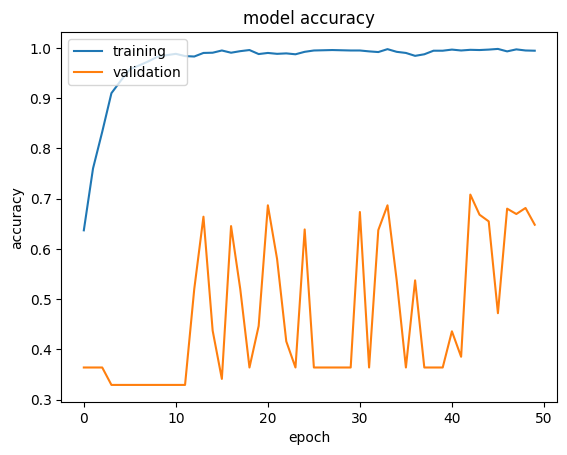

In [15]:
# Plot training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

What do you think about this curves? Do you think that training was properly done? Can you think of ways to improve it?

## **Section 3: Perform cross validation predictions with another 100 simulations per model. Those were not seen by the network during training**

Now we are going to test the trained model using the test set. These are new simulations that were not used by the network during the training. The idea here is to use simulaiton as if they are our real data (we call this pseudoobserved data in ABC) and see what the network predicts for each of these simulations. After that we compare the predicted values with the real (simulated) ones.

300 300
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step


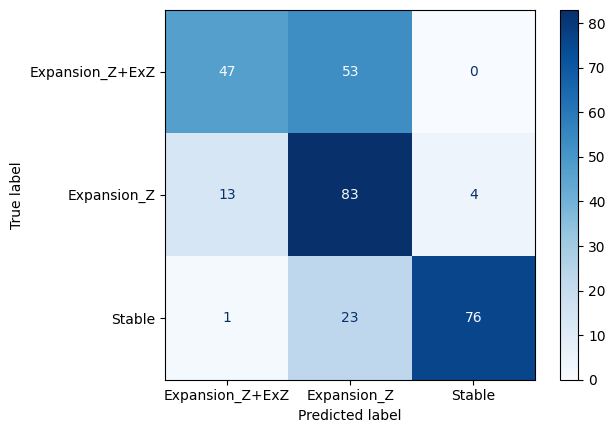

In [16]:
# Load Numpy test set arrays containing the test set simulations.
u1 = np.load("/content/Part1_Dem_Models_simulations/simulations/testSims/simModel1.npy",mmap_mode='r') #Expansion in both
u2 = np.load("/content/Part1_Dem_Models_simulations/simulations/testSims/simModel2.npy",mmap_mode='r') #Expansion in Zonal only
u3 = np.load("/content/Part1_Dem_Models_simulations/simulations/testSims/simModel3.npy",mmap_mode='r') #No expansion

# Combine all test set arrays.
xtest=np.concatenate((u1,u2,u3),axis=0)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(xtest):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      xtest[arr][idx][xtest[arr][idx] == 1] = -1
      xtest[arr][idx][xtest[arr][idx] == 0] = 1
    else:
      xtest[arr][idx][xtest[arr][idx] == 0] = -1

# Label each simulated array.
ytest=[0 for i in range(len(u1))]
ytest.extend([1 for i in range(len(u2))])
ytest.extend([2 for i in range(len(u3))])
ytest = np.array(ytest)

#delete temporary files to free memory.
del (u1,u2,u3)

# Print label and simulations length, these should be the same.
print (len(xtest), len(ytest))

#Add missing data (coded as 0s) to the simulated matrices
# as a percentage according to the empirical data (15% in E. segueriana).
missD_perc = 15
missD = int(xtest.shape[1]*xtest.shape[2]*(missD_perc/100))
for i in range(xtest.shape[0]):
    indices_2d = np.random.choice(xtest.shape[1], size=missD, replace=True)
    indices_3d = np.random.choice(xtest.shape[2], size=missD, replace=True)
    xtest[i, indices_2d, indices_3d] = 0
del(missD)

# Predict with the trained model and export a confusion matrix.
pred = model.predict(xtest)
pred_cat = [i.argmax() for i in pred]
cm=confusion_matrix(ytest, pred_cat)
scenarios = ['Expansion_Z+ExZ', 'Expansion_Z', 'Stable']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scenarios)

disp.plot(cmap=plt.cm.Blues)
plt.show()

Please take a moment to analyze the confusion matrix. Can you detect which models are more difficult to predict? For those, what is the other model that is creating this confusion?

The architecture we used above was the same we used on the paper. The only difference here is the size of the training data, which has less simulations here (1,000 per model against 10,000 per model in the paper). Now let's try to improve our results by changing the network architecture. Can you think about ways to improve it based on what we discussed? I added some the code to build a modified architecture below. Take a look on the results and think about the modifications I made on the architecture.

In [17]:
# Define the CNN architecture. You can now change some parts of it and see how it behaves.
def create_cnn(xtest):
	inputShape = (xtest.shape[1], xtest.shape[2])
	## image size. images need to have EXACTLY the same size
	inputs = Input(shape=inputShape)
	x = inputs
	## 1D convolution - less computational intensive and is also invariant to the samples order;
	x = Conv1D(64, kernel_size=2, activation='relu', kernel_regularizer=l1_l2(0.001))(x)
	x = Dropout(0.5)(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(64, kernel_size=2, activation='relu', kernel_regularizer=l1_l2(0.001))(x)
	x = Dropout(0.5)(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	### Linearising the image as in the initial step. From this point on the network behaves as a Multi-Layer Perceptron.
	x = Flatten()(x)
	x = Dense(32, activation='relu', kernel_regularizer=l1_l2(0.001))(x)
	x = Dropout(0.5)(x)
	x = Dense(32, activation='relu', kernel_regularizer=l1_l2(0.001))(x)
	x = Dropout(0.5)(x)
	x = Dense(num_classes, activation="softmax")(x)

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

In [18]:
# Create the CNN network.
model = create_cnn(xtest)

# Compile the CNN.
model.compile(loss=keras.losses.categorical_crossentropy,
	              optimizer='Adam',
	              metrics=['accuracy'])

# We will use early stopping and save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=50, verbose=0, mode='max', restore_best_weights=True)
### stop training when validation error increases (wait 25 epochs to see if there is any improvement).

# Check the architecture.
model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 1000, 270)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 999, 64)        │        34,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 999, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_3             │ (None, 499, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 499, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 498, 64)        │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 498, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_4             │ (None, 249, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 249, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 15936)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │       509,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 554,531 (2.12 MB)

 Trainable params: 554,275 (2.11 MB)

 Non-trainable params: 256 (1.00 KB)

In [19]:
#Run the CNN
history = model.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=150,
          verbose=1,
          validation_data=(xval, yval),callbacks=[earlyStopping])

# Save the model.
model.save(filepath='Trained_Esegueriana._MissingData.acc.keras')

Epoch 1/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 16s 445ms/step - accuracy: 0.4355 - loss: 8.7118 - val_accuracy: 0.3640 - val_loss: 13.4166
Epoch 2/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.5698 - loss: 7.9807 - val_accuracy: 0.3640 - val_loss: 10.4646
Epoch 3/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.6098 - loss: 7.3304 - val_accuracy: 0.3293 - val_loss: 7.3745
Epoch 4/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.6195 - loss: 6.6925 - val_accuracy: 0.3293 - val_loss: 6.8272
Epoch 5/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.6656 - loss: 6.0727 - val_accuracy: 0.3293 - val_loss: 6.4160
Epoch 6/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6592 - loss: 5.5111 - val_accuracy: 0.3293 - val_loss: 6.4234
Epoch 7/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - accuracy: 0.6904 - loss: 4.9693 - val_accuracy: 0.3293 - val_loss: 6.1111
Epoch 8/150
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.6912 - loss: 4.5360 - val_accuracy

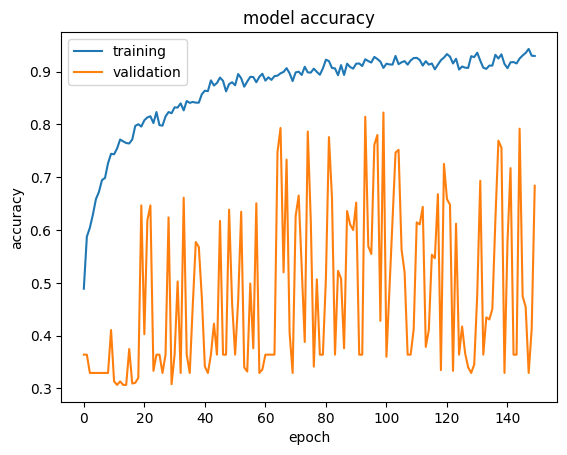

In [20]:
# Plot training and validation accuracies
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper left')
plt.show()

10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step


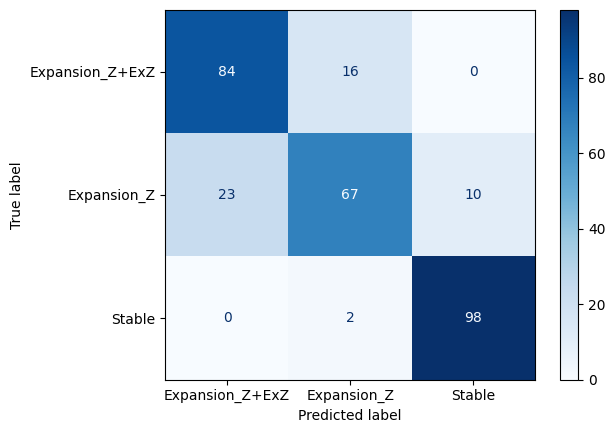

In [21]:
# Predict with the trained model and export a confusion matrix.
pred = model.predict(xtest)
pred_cat = [i.argmax() for i in pred]
cm=confusion_matrix(ytest, pred_cat)
scenarios = ['Expansion_Z+ExZ', 'Expansion_Z', 'Stable']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=scenarios)

disp.plot(cmap=plt.cm.Blues)
plt.show()

## **Section 4: Predict the most likely model for the empirical data, using the trained CNN.**

In [22]:
# Load empirical data.
infile=np.loadtxt("/content/Part1_Dem_Models_simulations/Part1_Dem_Models_Esegueriana.txt")
inp=np.array(infile)

inp.shape

(12125, 270)

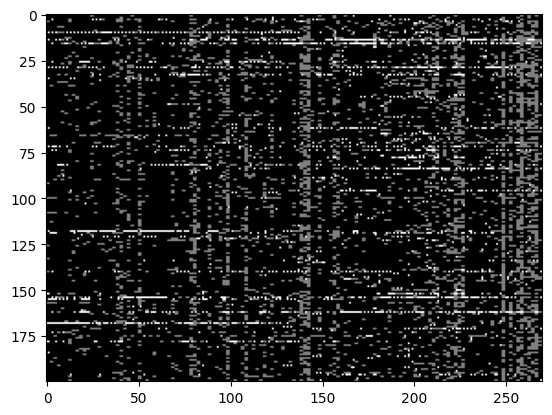

In [23]:
plt.imshow(inp[500:700],cmap='gray', vmin=-1, vmax=1)

In [24]:
# Create 100 subsets containing 1,000 random SNPs from the full empirical data.
num_samples=100
res = []
for i in range(0,num_samples):
	idx = np.random.choice(inp.shape[0], 1000, replace=False)
	n = inp[idx,:]
	res.append(np.array(n))

Emp = np.array(res)

# Predict model probabilities for each of the 100 subsets.
Emp_pred = model.predict(Emp)

# Print for each subset
print(Emp_pred)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 208ms/step
[[8.76402557e-01 1.23585179e-01 1.22062220e-05]
 [9.76013899e-01 2.39855293e-02 5.39556822e-07]
 [9.32806313e-01 6.71898872e-02 3.80319102e-06]
 [6.78607583e-01 3.21160138e-01 2.32285121e-04]
 [8.44578743e-01 1.55393720e-01 2.75310231e-05]
 [9.15052056e-01 8.49338695e-02 1.40257516e-05]
 [8.42439055e-01 1.57534659e-01 2.63534494e-05]
 [9.26802158e-01 7.31946975e-02 3.11370354e-06]
 [9.58792508e-01 4.12062407e-02 1.26565783e-06]
 [9.43260789e-01 5.67365997e-02 2.53511166e-06]
 [9.56191719e-01 4.38069664e-02 1.27852672e-06]
 [9.19447124e-01 8.05464536e-02 6.52087829e-06]
 [9.76519465e-01 2.34801639e-02 3.36546236e-07]
 [9.12914693e-01 8.70752931e-02 9.97301595e-06]
 [9.44125533e-01 5.58711663e-02 3.33274443e-06]
 [6.92123950e-01 3.07664990e-01 2.11087972e-04]
 [8.51669908e-01 1.48293108e-01 3.69334230e-05]
 [9.76305723e-01 2.36939490e-02 3.76506620e-07]
 [9.72891688e-01 2.71078721e-02 4.83628014e-07]
 [9.72255647e-01 2.77437642e-02 5.46695048e-07]
 

In [25]:
Emp_pred.shape

(100, 3)

In [26]:
# Print the average of all subsets
np.mean(Emp_pred, axis=0)


array([8.5492045e-01, 1.4493285e-01, 1.4668894e-04], dtype=float32)

/tmp/ipython-input-27-1753417303.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pred[col], label=col, shade=True)
/tmp/ipython-input-27-1753417303.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pred[col], label=col, shade=True)
/tmp/ipython-input-27-1753417303.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df_pred[col], label=col, shade=True)


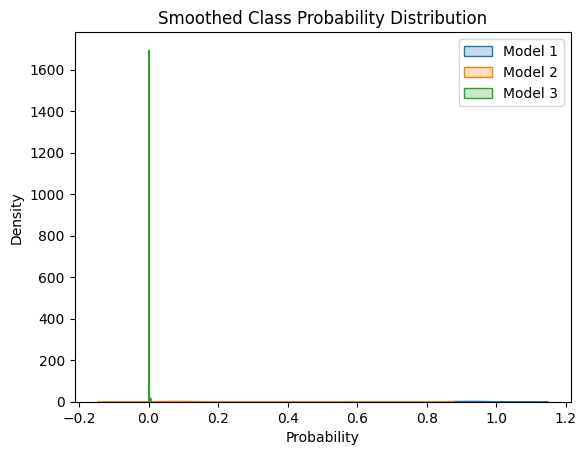

In [27]:
#Now plot a smoothed distribution of each class probability in the object Emp_pred

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming Emp_pred is already defined as in the provided code

# Convert Emp_pred to a pandas DataFrame for easier manipulation
df_pred = pd.DataFrame(Emp_pred, columns=['Model 1', 'Model 2', 'Model 3'])

# Calculate smoothed distributions (using kernel density estimation)
for col in df_pred.columns:
  sns.kdeplot(df_pred[col], label=col, shade=True)

plt.title('Smoothed Class Probability Distribution')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()

/tmp/ipython-input-28-862624198.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], label=col, shade=True)
/tmp/ipython-input-28-862624198.py:17: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[col], label=col, shade=True)


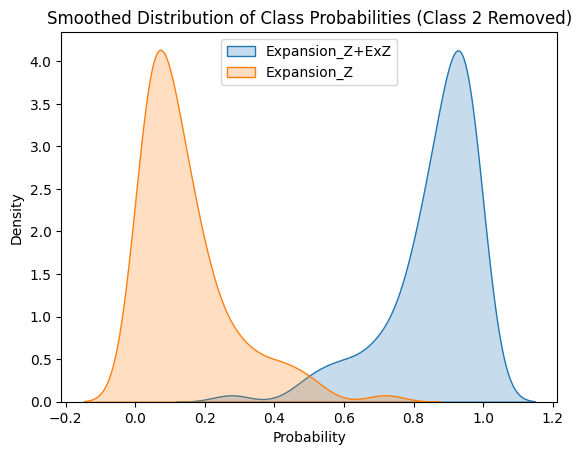

In [28]:
# Now plot a smoothed distribution of each class probability in the object Emp_pred. Remove class 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Assuming Emp_pred is already defined from the previous code
# Remove class 2 (third model, stable pops)
Emp_pred_filtered = np.delete(Emp_pred, 2, 1)

# Create a DataFrame for easier plotting
df = pd.DataFrame(Emp_pred_filtered, columns=['Expansion_Z+ExZ', 'Expansion_Z'])

# Plot smoothed distributions
for col in df.columns:
    sns.kdeplot(df[col], label=col, shade=True)

plt.title('Smoothed Distribution of Class Probabilities (Class 2 Removed)')
plt.xlabel('Probability')
plt.ylabel('Density')
plt.legend()
plt.show()


Which scenario was selected? Is this in agreement with the one obtained in the paper for *E. segueriana?* (model 2 - Zonal expansion only). Check with your colleagues whether they recovered the same scenario as you. If not, can you explain why this is the case?

## **Section 5: We can also perform parameter estimation.**

Now we can use the same architecture (with a slight difference in the last layer) to perform parameter estimation. To make things simple, we will focus only in the simulations under the selected scenario (model 2). We will also need to change the labels of each simulation to the parameter values used.

In [29]:
def create_cnn(xtest):
	inputShape = (xtest.shape[1], xtest.shape[2])
	## image size. images need to have EXACTLY the same size
	inputs = Input(shape=inputShape)
	x = inputs
	## 1D convolution - less computational intensive and is also invariant to the samples order;
	x = Conv1D(64, kernel_size=2, activation='relu',input_shape=(xtest.shape[1], xtest.shape[2]))(x)
	x = Dropout(0.5)(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	x = Conv1D(32, kernel_size=2, activation='relu')(x)
	x = Dropout(0.5)(x)
	### Enables the network to learn more complex features / shapes.
	x = AveragePooling1D(pool_size=2)(x)
	x = BatchNormalization()(x)
	### Linearising the image as in the initial step. From this point on the network behaves as a Multi-Layer Perceptron.
	x = Flatten()(x)
	x = Dense(32, activation='relu', kernel_regularizer=l1_l2(0.0001))(x)
	x = Dropout(0.5)(x)
	x = Dense(16, activation='relu', kernel_regularizer=l1_l2(0.0001))(x)
	x = Dropout(0.5)(x)
	x = Dense(numParams)(x)# This was the only change in the architecture.

	# Construct the CNN.
	model = Model(inputs, x)
	# Return the CNN.
	return model

In [30]:
from sklearn.preprocessing import StandardScaler

# Load parameters.
demogParams = np.loadtxt('/content/Part1_Dem_Models_simulations/simulations/trainingSims/parameters.txt')
y = np.array(demogParams)
numParams=y.shape[1]

#delete temporary files to free memory.


#We need to standard scale the parameters, as they can be on very different scales.
scaler= StandardScaler()
y = scaler.fit_transform(y)

#Load simulations for the best model.
u3 = np.load("/content/Part1_Dem_Models_simulations/simulations/trainingSims/simModel2.npy",mmap_mode='r')
x = np.array(u3)

#transform major alleles in -1 and minor 1
for arr,array in enumerate(x):
  for idx,row in enumerate(array):
    if np.count_nonzero(row) > len(row)/2:
      x[arr][idx][x[arr][idx] == 1] = -1
      x[arr][idx][x[arr][idx] == 0] = 1
    else:
      x[arr][idx][x[arr][idx] == 0] = -1

# Print label and simulations length, these should be the same.
print (len(x), len(y))

# Shuffle the arrays for training, keeping the labels in the same order.
shf = list(range(len(x)))
shuffle(shf)
y = y[shf]
x = x[shf]

#Add missing data (coded as 0s) to the simulated matrices
# as a percentage according to the empirical data (15% in E. segueriana).
missD_perc = 15
missD = int(x.shape[1]*x.shape[2]*(missD_perc/100))
for i in range(x.shape[0]):
    indices_2d = np.random.choice(x.shape[1], size=missD, replace=True)
    indices_3d = np.random.choice(x.shape[2], size=missD, replace=True)
    x[i, indices_2d, indices_3d] = 0
del(missD)

# Separate train (75%) and validate (25%) sets.
xtrain, xtest = x[int(len(y)*.25):], x[:int(len(y)*.25)]
ytrain, ytest = y[int(len(y)*.25):], y[:int(len(y)*.25)]
del(x)

# Create the CNN network.
cnn = create_cnn(xtest)

# Compile the CNN.
cnn.compile(loss='mean_squared_error', #the loss is now defined as the mean squared error, as we have continuous labels
	              optimizer='Adam')

# Check the architecture.
cnn.summary()

# Run the CNN with early stopping. Save the model with the best val_accuracy.
earlyStopping = EarlyStopping(monitor='val_loss', patience=25, verbose=0, mode='max', restore_best_weights=True)

history = cnn.fit(xtrain, ytrain, batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(xtest, ytest),callbacks=[earlyStopping])

1000 1000


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 1000, 270)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 999, 64)        │        34,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 999, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_5             │ (None, 499, 64)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 499, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_6 (Conv1D)               │ (None, 498, 32)        │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 498, 32)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_6             │ (None, 249, 32)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 249, 32)        │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 7968)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 32)             │       255,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 12)             │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 294,876 (1.12 MB)

 Trainable params: 294,684 (1.12 MB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step - loss: 3.8653 - val_loss: 3.6398
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 55ms/step - loss: 3.1928 - val_loss: 5.8616
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 2.9450 - val_loss: 6.8654
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - loss: 2.5932 - val_loss: 7.5481
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step - loss: 2.3726 - val_loss: 7.8709
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 2.1960 - val_loss: 6.9316
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 1.9515 - val_loss: 5.7456
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - loss: 1.8797 - val_loss: 5.3073
Epoch 9/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - loss: 1.8535 - val_loss: 4.5260
Epoch 10/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 1.7132 - val_loss: 3.8374
Epoch 11/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 1.6622 - val_loss: 3.1882
Epoch 12/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 1.5770 - val_loss: 2.7204
Ep

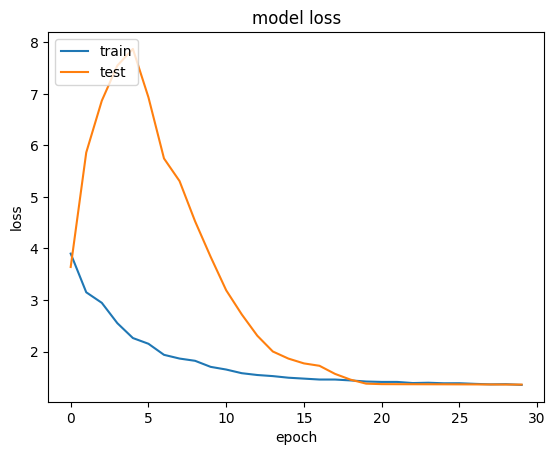

In [31]:
# Plot training and validation accuracies
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

##**Now let's predict the real data.**

In [34]:

# Create 100 subsets containing 1,000 random SNPs from the full empirical data.
num_samples=100
res = []
for i in range(0,num_samples):
	idx = np.random.choice(inp.shape[0], 1000, replace=False)
	n = inp[idx,:]
	res.append(np.array(n))

# Predict parameters.
Emp_pred = np.array(res)
Emp_pred = cnn.predict(Emp_pred)
Emp_pred = scaler.inverse_transform(Emp_pred)

#Print parameter names
print('Theta, T1, T2, T3, Ne, NeZ, NeZLGM, NeZPl, m12_LGM, m21_LGM, m12_Pl, m21_Pl')
#Print parameter values (averaged over subsets)
print(np.mean(Emp_pred, axis=0))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
Theta, T1, T2, T3, Ne, NeZ, NeZLGM, NeZPl, m12_LGM, m21_LGM, m12_Pl, m21_Pl
[ 2.7930304e-01  3.0304320e+06 -3.9010309e+04 -4.6514326e+03
  1.5344816e+05  4.1400867e+00  7.4335823e+01  1.0133076e+00
  2.5587988e+00  1.4785234e+00 -3.1289971e+00  9.3125677e+00]
